# 甲骨文字识别

# 1. 比赛介绍

## 1.1 比赛背景

甲骨文是我国迄今为止发现的最古老的成熟文字体系，由于其书写载体包括龟腹甲、龟背甲、牛肩胛骨等，人们将它命名为“甲骨文”。  
甲骨文记录了中国古代文明、中国文化以及古代人类的思维思想。通过甲骨文，我们可以了解到中国古代的历史事件和社会生活。  
因此对甲骨文进行研究会极大地帮助我们探索中国文字的源流，研究汉字的发展规律。  
尽管在过去的 120 年的时间里，经过几代考古学家和历史学家的努力，甲骨文的解读和考释等研究已经取得了一定的进展。  
但作为一门冷门学科，甲骨文仍有许多方面需要进行进一步探究。目前仍有很多甲骨文字符的含义未被确认，  
破译工作还有很多难关需要攻破。  
甲骨文识别的任务是确定甲骨文的字符类别，其主要工作是对甲骨文字进行正确的分类操作。它是完成甲骨文释读的必要前提条件。  
快速精确地对甲骨文进行识别将会对甲骨文的释读工作起到很大的促进作用。  
目前的甲骨文识别工作主要依赖于学科专家，需要专家拥有丰富的甲骨文专业知识和识别经验，也需要付出大量的时间。  
这就造成了甲骨文识别的研究成本高、研究效率低的问题。  
如今，人工智能技术迭代非常迅速。随着技术不断发展，越来越多的研究尝试将深度神经网络应用于图像识别任务中。  
因此本比赛尝试使用深度学习来完成甲骨文字识别。  

## 1.2 数据集说明

该比赛所使用的数据集来自“殷契文渊”平台提供的 HWOBC 数据集，“殷契文渊”平台是世界上现有的资料最齐全、最规范、最权威的甲骨文数据平台，对全世界免费开放，改变了过去甲骨文研究的“窘境”。  
经过筛选保留了 376 种已破译的甲骨文字符，其中每个类别平均包含 100 张以上的字符图片，分为训练集和测试集。

- 数据展示


 
<div class='insertContainerBox row'>
<div class='insertItem' align=center><img src="https://imgbed.momodel.cn/20231202093532.png" width="200px"/></div>
   <div class='insertItem' align=center><img src="https://imgbed.momodel.cn/20231202093548.png" width="200px"/></div> 
       <div class='insertItem' align=center><img src="https://imgbed.momodel.cn/20231202093607.png" width="200px"/></div> 
    <div class='insertItem' align=center><img src="https://imgbed.momodel.cn/20231202093630.png" width="200px"/></div> 
</div>

# 2. 数据集分析和可视化

## 2.1 数据大小统计

首先对甲骨文字数据集中训练集和测试集的图片数量按照不同类别进行统计分析

In [1]:
import os
print("当前工作路径" + os.getcwd())


当前工作路径/home/jovyan/work


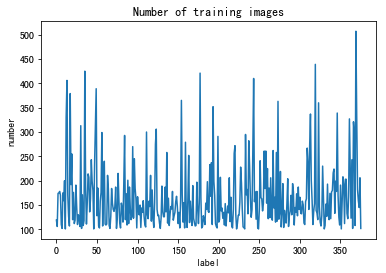

In [2]:
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

trainpath="/home/jovyan/work/datasets/666be34edcb9f32d6c981720-momodel/train"
wordlen=[]
for file in os.listdir(trainpath):
    if file!='.DS_Store':
        filepath=os.path.join(trainpath,file)
        length=len(os.listdir(filepath))
        wordlen.append(length)

plt.plot(range(0,376),wordlen)
plt.xlabel("label")
plt.ylabel("number")
plt.title("Number of training images")
plt.show()


从图中可以看出，数据集中共有 376 个不同类别的甲骨文字，训练集中每个类别平均有 100 到 200 张字符图片，测试集中每个类别平均有 20 到 30 张甲骨文字符图片。  
因为公开的甲骨文字数据集较少，所以用于训练和测试的图片数量较少。  
为了让构建的神经网络模型进行充分的学习，利用了数据增强的方法，在不产生文字歧义下（即变换后为另一个字）将图片进行翻转、平移等操作，以扩充数据集。

## 2.2 甲骨文字符分析

进一步分析每一个类别所包含的甲骨文字，可以发现同一个现代汉字所对应的甲骨文在字形上可能有多种，且彼此之间差异还是较大的。  
如下图所示，为“车”字所对应的四种不同的甲骨文字。因此，这也为模型训练和识别增加了难度。


<div class='insertContainerBox row'>
<div class='insertItem' align=center><img src="https://imgbed.momodel.cn/20231202093921.png" width="100px"/></div>
    <div class='insertItem' align=center><img src="https://imgbed.momodel.cn/20231202093940.png" width="100px"/></div>
    <div class='insertItem' align=center><img src="https://imgbed.momodel.cn/20231202093957.png" width="100px"/></div>
    <div class='insertItem' align=center><img src="https://imgbed.momodel.cn/20231202094017.png" width="100px"/></div>
</div>


# 3. 模型构建


## 3.1  导入所需的库

In [3]:
import cv2
import os
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt


2024-06-15 09:42:33.625177: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory
2024-06-15 09:42:33.625196: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## 3.2 导入数据集

In [4]:
train_dir = '/home/jovyan/work/datasets/666be34edcb9f32d6c981720-momodel/train'
test_dir = '/home/jovyan/work/datasets/666be34edcb9f32d6c981720-momodel/test'

# 将每个像素归一化
train_images = ImageDataGenerator(rescale = 1/255)
test_images = ImageDataGenerator(rescale = 1/255)

im_size = 150
batch_size = 20


In [5]:
from pathlib import Path


In [6]:
# 将每个像素归一化
train_images = ImageDataGenerator(rescale = 1/255)
test_images = ImageDataGenerator(rescale = 1/255)


In [7]:
# 载入图片，批处理大小，shuffle，size
train_gen = train_images.flow_from_directory(directory=train_dir,
                                             batch_size=batch_size,
                                             shuffle=True,
                                             target_size=(im_size, im_size),
                                             class_mode='categorical')

# 载入测试集
val_gen = test_images.flow_from_directory(directory=test_dir,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          target_size=(im_size, im_size),
                                          class_mode='categorical')


Found 62589 images belonging to 376 classes.
Found 3988 images belonging to 376 classes.


In [8]:
# 查看class数目
print(train_gen.num_classes)


376


## 3.3 模型构建

In [9]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.ZeroPadding2D(((1,2),(1,2)),input_shape=(150,150, 3)))
model.add(tf.keras.layers.Conv2D(filters = 24,
                                 kernel_size = (5,5),
                                 strides = 4,
                                 activation = "relu"))
model.add(tf.keras.layers.MaxPooling2D(pool_size = (3, 3),strides = 2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(0.6))
model.add(tf.keras.layers.Dense(376, activation='softmax'))


2024-06-15 09:42:45.405332: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-06-15 09:42:45.405410: W tensorflow/stream_executor/cuda/cuda_driver.cc:312] failed call to cuInit: UNKNOWN ERROR (303)
2024-06-15 09:42:45.405472: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (notebook): /proc/driver/nvidia/version does not exist
2024-06-15 09:42:45.406301: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-15 09:42:45.419815: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 3191990000 Hz

In [10]:
# 显示模型结构
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d (ZeroPadding2 (None, 153, 153, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 38, 38, 24)        1824      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 18, 18, 24)        0         
_________________________________________________________________
flatten (Flatten)            (None, 7776)              0         
_________________________________________________________________
dropout (Dropout)            (None, 7776)              0         
_________________________________________________________________
dense (Dense)                (None, 376)               2924152   
Total params: 2,925,976
Trainable params: 2,925,976
Non-trainable params: 0
______________________________________________

## 3.4 模型训练

In [ ]:
# # compile模型
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['acc'])
history = model.fit(train_gen,epochs=1,validation_data=val_gen)


In [13]:
model_path = '/home/jovyan/work/results/model_cnn.h5'
model.save(model_path)


## 3.5 模型测试


训练完成后，在 notebook 中加载模型进行推理，并展示推理结果。  

预测类别： 247
真实类别:  136


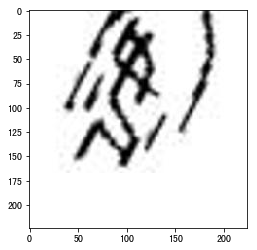

In [14]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2

import matplotlib.pyplot as plt

# 测试保存的模型是否正常工作
pre_model = tf.keras.models.load_model(model_path)
img = cv2.imread(str(Path(test_dir) / Path('安/42_F1FA-4.jpg')), 1)
plt.imshow(img)
img = cv2.resize(img, (150, 150))
img = img.reshape(1, 150, 150, 3)
img = img / 255

predict = pre_model.predict(img)
print("预测类别：", np.argmax(predict))

print("真实类别: ", val_gen.class_indices['安'])


# 4. 评分

**注意：**

通过对以上步骤流程的了解，相信大家对该任务有了深刻的认识，但是模型比较简单，    
准确率也不高，大家可以试着写自己的模型，并将其调到最佳状态。   

1. 你可以在我们准好的接口中实现模型（若使用可以修改函数接口），也可以自己实现深度学习模型，写好代码后可以在 Py 文件中使用 CPU 进行模型训练。
2. 在训练模型等过程中如果需要**保存数据、模型**等请写到 **results** 文件夹，如果采用 [离线任务](https://momodel.cn/docs/#/zh-cn/%E5%9C%A8GPU%E6%88%96CPU%E8%B5%84%E6%BA%90%E4%B8%8A%E8%AE%AD%E7%BB%83%E6%9C%BA%E5%99%A8%E5%AD%A6%E4%B9%A0%E6%A8%A1%E5%9E%8B) 请务必将模型保存在 **results** 文件夹下。
3. 训练出自己最好的模型后，先按照下列 cell 操作方式实现 NoteBook 加载模型测试；请测试通过再进行【系统测试】。
4. 请将你的数据预处理函数进行修改为`process_data()`的格式，能够对后台的测试数据进行处理以便对你的模型进行测试打分。
5. 测试数据的格式与你所使用的数据相同，为csv文件。
6. 在修改 `process_data()` 函数时请务必注意，请保持测试数据集顺序与原始顺序一致，避免对测试数据的排序结果和原排序结果不同导致测试结果的偏差。
7. 请填写你的模型路径及名称并补充 `predict()` 函数以实现预测。
8. 点击左侧栏提交结果后点击生成文件则需勾选 `process_data()` 函数和 `predict()` 函数的 cell。
9. 请导入必要的包和第三方库 (包括此文件中曾经导入过的)。
10. 请加载你认为训练最佳的模型，即请按要求填写模型路径。
11. 测试提交时服务端会调用 `process_data()` 函数和 `predict()` 函数，请不要修改该函数的输入输出及其数据类型。

========================================  **模型预测代码答题区域**  ===========================================  
在下方的代码块中编写 **数据处理 process_data()** 和 **模型预测 predict()** 部分的代码，请勿在别的位置作答  
提交文件 `main.py` 中需要包含 `process_data()` 函数和 `predict()` 函数，提交文件样例参考 `main.py`

In [ ]:
def process_data(data_dir):
    """
    原始数据处理
    param:
        data_dir: str, 数据集文件夹路径
    return:
        X: 经过预处理和特征选择后的特征数据
        labels: np.ndarray, 标签数据
    """
    new_features,label = None, None
    # -------------------------- 实现数据处理和特征选择部分代码 ----------------------------

    # ------------------------------------------------------------------------
    # 返回筛选后的数据
    return X, labels


In [ ]:
# -------------------------- 请加载最满意的模型 ---------------------------
# 加载模型(请加载你认为的最佳模型)
# 加载模型,加载请注意 model_path 是相对路径, 与当前文件同级。
# 如果你的模型是在 results 文件夹下的 my_model.m 模型，则 model_path = './results/my_model.m'
path = None

# 加载模型
model = None


def predict(X):
    """
    模型预测
    param：
        X : 特征数据，是 process_data 函数的返回值之一。
    return：
        y_predict : np.ndarray, 数据预测标签。
    """

    # -------------------------- 实现模型预测部分的代码 ---------------------------
    # 获取输入的类别
    y_predict = None

    # -------------------------------------------------------------------------

    # 返回类别
    return y_predict


========================================  **测试提交函数示例**  =========================================== 

In [22]:
def process_data(data_dir):
    """
    原始数据处理
    param:
        data_dir: str, 数据集文件夹路径
    return:
        X: 经过预处理和特征选择后的特征数据
        labels: np.ndarray, 标签数据
    """

    import cv2
    import os
    from tensorflow.keras.preprocessing.image import ImageDataGenerator

    im_size = 150
    batch_size = 20

    # 将每个像素归一化
    images = ImageDataGenerator(rescale = 1/255)

    # 载入图片，批处理大小，shuffle，size
    img = images.flow_from_directory(directory=data_dir,
                                                 batch_size=batch_size,
                                                 shuffle=False,
                                                 target_size=(im_size, im_size),
                                                 class_mode=None)# 载入图片，批处理大小，shuffle，size
    X = img
    labels = img.classes

    return X, labels


In [23]:
# 编写符合测试需求的方法
from tensorflow.keras.models import load_model

# 加载模型,加载请注意 path 是相对路径, 与当前文件同级。
path = "./results/model_cnn.h5"
model = load_model(path)

def predict(X):
    """
    模型预测
    param：
        X : 甲骨文数据对应的特征数据。
    return：
        y_predict : np.ndarray, 数据预测标签。
    """

    prediction = model.predict(X)
    y_predict = prediction.argmax(axis=1)
    return y_predict
